## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pdb;
import math
import scipy.linalg as sc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA

# Global variables

In [ ]:
# path to images in your google drive
data_path = '/content/drive/MyDrive/Assignments/Year_3/Term_2/Pattern/face_recognition_lab01/archive/'
data_path_osos = '/content/drive/MyDrive/Face_Recognition_Lab/samples/'
non_face_images_path = '/content/drive/MyDrive/Assignments/Year_3/Term_2/Pattern/face_recognition_lab01/cars'

### Upload data from google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Generating Data matrix and labels vector


The following function extracts a **P5** pgm file and returns a list of lists that contains the image's data as integers between 0 (**black**) and 255 (**white**)

credits goes to the following stackoverflow answer: [link](https://stackoverflow.com/questions/35723865/read-a-pgm-file-in-python)

In [ ]:
def read_image_as_pgmf(f):
  with open(f, 'rb') as pgmf:
      im = plt.imread(pgmf)
  return im

Generates a list of matrices containing each photo, and generates the label vector


In [ ]:
def generate_list_image_matrix_and_label():
  images = np.zeros((400, 112, 92))
  labels = np.zeros((400))
  current_matrix = 0
  for subject_num in range(1, 41):
    for image_num in range(1, 11):
      dir = data_path + "s" + str(subject_num) + "/" + str(image_num) + ".pgm"
      images[current_matrix, ] = read_image_as_pgmf(dir)
      labels[current_matrix] = subject_num
      current_matrix += 1
  return images, labels

Converts list of matrices into required data matrix(400, 10304)

In [ ]:
def generate_data_matrix_and_label():
  images, labels = generate_list_image_matrix_and_label()
  data_matrix = np.zeros((len(images), 10304))
  current_image = 0
  for image in images:
    data_matrix[current_image, :] = image.flatten()
    current_image += 1
    # np.append(data_matrix, image.flatten())
  return data_matrix, labels

# Split into training and test sets

In [ ]:
def split_data(data_matrix, labels):
  training_set = data_matrix[::2]
  test_set = data_matrix[1::2]
  training_set_labels = labels[::2]
  test_set_labels = labels[1::2]
  return training_set, training_set_labels, test_set, test_set_labels

In [ ]:
data_matrix, labels = generate_data_matrix_and_label()
training_set, training_set_labels, test_set, test_set_labels =  split_data(data_matrix, labels)

# PCA


In [ ]:
def PCA(data_matrix, acceptance_ratio):
  dim_means                   =   np.mean(data_matrix, axis=0)
  centered_data               =   data_matrix - dim_means
  covariance                  =   (1/(len(data_matrix) - 1)) * np.inner(np.transpose(centered_data), np.transpose(centered_data))

  e_values, e_vectors         =   np.linalg.eigh(covariance)
  e_values = np.flip(e_values, 0)
  e_vectors = np.flip(e_vectors, 1)

  current_ratio               =   0.0
  # eigen_sum                   =   sum(e_values)
  # projection_matrix           =   []

  # for i in range(len(e_values)):
  #   if current_ratio / eigen_sum >= acceptance_ratio:
  #     break;
  #   current_ratio += e_values[i]
  #   projection_matrix.append(e_vectors[:, i])

  eigen_sum = np.sum(e_values)

  cumulative_ratios = np.cumsum(e_values)
  relevant_indices = np.where(cumulative_ratios / eigen_sum < acceptance_ratio)[0]

  # Preallocate projection_matrix
  projection_matrix = np.zeros((e_vectors.shape[0], len(relevant_indices)))

  for idx, i in enumerate(relevant_indices):
      current_ratio += e_values[i]
      projection_matrix[:, idx] = e_vectors[:, i]


  return projection_matrix

In [ ]:
test = np.array([[10, 60, 90],
                        [20, 50, 70],
                        [30, 50, 40],
                        [20, 50, 60],
                        [10, 60, 10]])
p_m = PCA(test, 1)
print(p_m)

(3, 3)
[[-0.01642407  0.85025739]
 [-0.02146802 -0.5263604 ]
 [ 0.99963462  0.00266574]]


In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]

for i in alpha:
  projection_matrix          =     PCA(training_set, i)

# b) Project the training set, and test sets separately using the same projection matrix
  # projection_matrix_trans    =     np.transpose(projection_matrix)
  # projected_train = np.inner(projection_matrix_trans, training_set)
  # projected_test = np.inner(projection_matrix_trans, test_set)


  projected_train = np.dot(training_set, projection_matrix)
  projected_test = np.dot(test_set, projection_matrix)

  knn_classifier             =    KNeighborsClassifier(n_neighbors=1)
  knn_classifier.fit(projected_train, training_set_labels)
  predicted_labels           =    knn_classifier.predict(projected_test)

  accuracy                   =    accuracy_score(test_set_labels, predicted_labels)
  print("Alpha:", i, ",  Accuracy:", accuracy)

Alpha: 0.8 ,  Accuracy: 0.95
Alpha: 0.85 ,  Accuracy: 0.95
Alpha: 0.9 ,  Accuracy: 0.94
Alpha: 0.95 ,  Accuracy: 0.94


**Explanation**<br>

As alpha increases, more principal components are introduced, <br>
capturing more variance in the data. <br>
This might lead to better representation of the original data in the <br>reduced-dimensional space.<br>
However, introducing more components also means higher-dimensional data, which could introduce noise or irrelevant information.<br>

It seems that as alpha increases, accuracy remains relatively stable or slightly decreases. This could suggest that there's a spot for alpha where we can capture enough variance to represent the data well and also avoiding overfitting or including irrelevant information.

**Classifier Tuning**

Alpha: 0.8 ,  Accuracy: 0.95
Alpha: 0.8 ,  Accuracy: 0.895
Alpha: 0.8 ,  Accuracy: 0.845
Alpha: 0.8 ,  Accuracy: 0.805


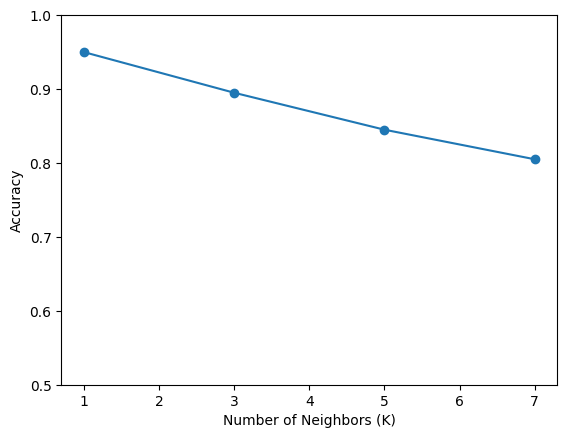

Alpha: 0.85 ,  Accuracy: 0.95
Alpha: 0.85 ,  Accuracy: 0.89
Alpha: 0.85 ,  Accuracy: 0.845
Alpha: 0.85 ,  Accuracy: 0.775


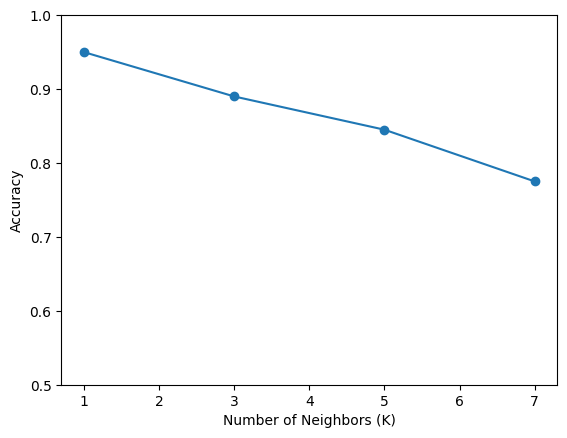

Alpha: 0.9 ,  Accuracy: 0.94
Alpha: 0.9 ,  Accuracy: 0.885
Alpha: 0.9 ,  Accuracy: 0.84
Alpha: 0.9 ,  Accuracy: 0.765


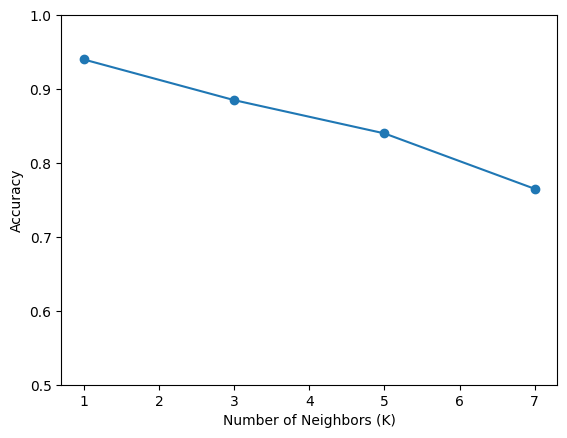

Alpha: 0.95 ,  Accuracy: 0.94
Alpha: 0.95 ,  Accuracy: 0.895
Alpha: 0.95 ,  Accuracy: 0.845
Alpha: 0.95 ,  Accuracy: 0.74


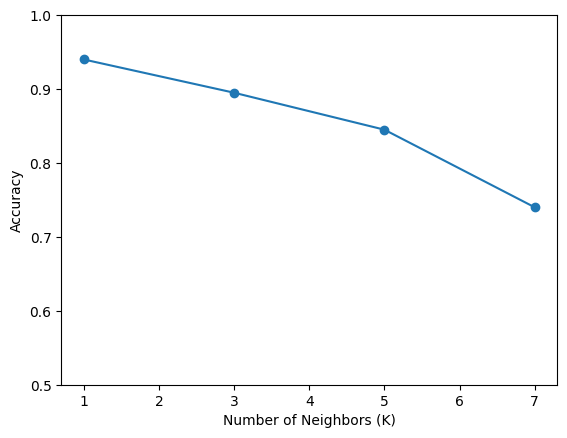

In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]

for i in alpha:
  projection_matrix          =     PCA(training_set, i)

  projected_train = np.dot(training_set, projection_matrix)
  projected_test = np.dot(test_set, projection_matrix)

  accuracies = []
  k_values = [1, 3, 5, 7]

  for k in k_values:
      knn_classifier = KNeighborsClassifier(n_neighbors=k)
      knn_classifier.fit(projected_train, training_set_labels)

      predicted_labels = knn_classifier.predict(projected_test)
      accuracy = accuracy_score(test_set_labels, predicted_labels)
      print("Alpha:", i, ",  Accuracy:", accuracy)
      accuracies.append(accuracy)

  plt.plot(k_values, accuracies, marker='o')
  plt.xlabel('Number of Neighbors (K)')
  plt.ylabel('Accuracy')
  plt.ylim(0.5, 1)
  plt.show()


# LDA


In [ ]:
def calcMean(data):
  return np.mean(data, axis=0)


In [ ]:
def classMeans(data, labels, num_classes):
  means = dict()
  for i in range(1, num_classes + 1):
    point_vectors = np.where(labels==i)
    vectors = np.take(data, point_vectors, axis = 0)
    means[i] = np.mean(vectors, axis = 1)
  return means


In [ ]:
def calculateScatter(data, labels, num_classes):
  class_means = classMeans(data, labels, num_classes)
  mean = calcMean(data)
  S = np.zeros((len(data[0]), len(data[0])))
  B = np.zeros((len(data[0]), len(data[0])))

  for i in range(1, num_classes):
    point_vectors = np.where(labels == i)
    X = np.take(data, point_vectors, axis=0)[0] - class_means[i][0]
    S += np.dot(X.T, X) # withen-class scatter
    k = len(np.where(labels == i)[0])
    currentMean = class_means[i][0].reshape(len(data[0]), 1)
    mean = mean.reshape(len(data[0]), 1)
    B += k * (currentMean - mean).dot((currentMean - mean).T)

  return S, B

In [ ]:
def LDA(data, labels, num):
  num_classes = len(np.unique(labels))
  S, B = calculateScatter(data, labels, num_classes)

  W = np.dot(sc.pinv(S), B) #transformation matrix
  eigen_values, eigen_vectors = sc.eig(W)



  eigen_values = np.real(eigen_values)
  eigen_vectors = np.real(eigen_vectors)
  eigen_values = np.abs(eigen_values)
  asc_sort = eigen_values.argsort()


  eigen_values = np.flip(eigen_values[asc_sort])
  eigen_vectors = np.flip(eigen_vectors[:, asc_sort], axis=1)
  proj_matrix = eigen_vectors[:, :num]
  return proj_matrix


In [ ]:
proj_matrix = LDA(training_set, training_set_labels, 39)

In [ ]:

# b) Project the training set, and test sets separately using the same projection matrix
# projected_train = np.matmul(training_set - np.mean(training_set, axis=0), proj_matrix)
# projected_test = np.matmul(test_set - np.mean(test_set, axis=0), proj_matrix)

projected_train = np.dot(training_set, proj_matrix)
projected_test = np.dot(test_set, proj_matrix)

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(projected_train, training_set_labels)
predicted_labels = knn_classifier.predict(projected_test)

accuracy = accuracy_score(test_set_labels, predicted_labels)
print("Accuracy:", accuracy)


In [ ]:

accuracies = []

k_values = [1, 3, 5, 7]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(projected_train, training_set_labels)

    predicted_labels = knn_classifier.predict(projected_test)
    accuracy = accuracy_score(test_set_labels, predicted_labels)
    print(accuracy)
    accuracies.append(accuracy)

plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.show()


# Face vs Non-face Images

In [ ]:
number_of_images = 814

def flatten_nonface_images(nonface_images):
  nonface_images_flattened = np.zeros((number_of_images, 92*112))
  counter = 0
  for i in range(number_of_images):
    nonface_images_flattened[counter, :] = nonface_images[counter, :].flatten()
    counter += 1
  return nonface_images_flattened

def load_nonface_images():
  nonface_images = np.zeros((number_of_images, 112, 92))
  counter = 0
  for i in range(1, 1301):
    try:
      image = np.asarray(Image.open(non_face_images_path + '/' +  str(i) + '.jpg'))
      nonface_images[counter, :] = resize_image(image)
      counter += 1
    except FileNotFoundError:
      continue
  return nonface_images

def resize_image(original_image):
    resized_image = cv2.resize(original_image, (92, 112))
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    return grayscale_image
nonface_images = load_nonface_images()
nonface_images_flattened = flatten_nonface_images(nonface_images)


In [ ]:
def get_test_data(number_non_face):
  train_data = np.concatenate((data_matrix, nonface_images_flattened[0:number_non_face]), axis=0)
  train_labels = np.concatenate((np.ones(data_matrix.shape[0]), np.zeros(nonface_images_flattened.shape[0])))

  train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.5, random_state=34)
  return train_data, test_data, train_labels, test_labels

train_data, test_data, train_labels, test_labels = get_test_data(number_of_images)

In [ ]:
print(test_data_projected_lda.shape)

(607, 2)


In [ ]:
def prepare_test_data(train_data, test_data, labels=train_labels):
  proj_matrix_pca = PCA(train_data, 0.5)
  proj_matrix_lda = LDA(train_data, labels + 1, 1)

  train_data_projected_pca = np.dot(train_data, proj_matrix_pca)
  test_data_projected_pca = np.dot(test_data, proj_matrix_pca)

  train_data_projected_lda = np.dot(train_data, proj_matrix_lda)
  test_data_projected_lda = np.dot(test_data, proj_matrix_lda)
  return train_data_projected_pca, test_data_projected_pca, train_data_projected_lda, test_data_projected_lda


def classify_face_noface_images(train_data_projected, test_data_projected, train_labels, test_labels):
  classifier = KNeighborsClassifier(n_neighbors = 5)
  classifier.fit(train_data_projected, train_labels)

  prediction = classifier.predict(test_data_projected)
  accuracy = accuracy_score(test_labels, prediction)
  print(accuracy)
  return prediction

train_data_projected_pca, test_data_projected_pca, train_data_projected_lda, test_data_projected_lda = prepare_test_data(train_data, test_data)
print('Accuracy for PCA')
prediction_pca = classify_face_noface_images(train_data_projected_pca, test_data_projected_pca, train_labels, test_labels)
print('Accuracy for LDA')
prediction_lda = classify_face_noface_images(train_data_projected_lda, test_data_projected_lda, train_labels, test_labels)

Accuracy for PCA
0.9275123558484349
Accuracy for LDA
0.8780889621087314


## 1. Failure and success cases

In [ ]:
def print_imgs(indices, labels, prediction):
  cols = 4
  rows = len(indices) // cols
  rows += len(indices) % cols

  fig, axes = plt.subplots(rows, cols, figsize=(20, rows*3))

  for i, index in enumerate(indices):
      ax = axes[i // cols, i % cols] if len(indices) > 1 else axes
      ax.imshow(np.reshape(test_data[index, :], (112, 92)), cmap='gray')
      ax.set_title(f"Actual: {labels[index]}, Predicted: {prediction[index]}")
      ax.axis("off")  # Turn off axis labels

  plt.tight_layout()
  plt.show()



### PCA Wrong prediction

PCA wrong prediction


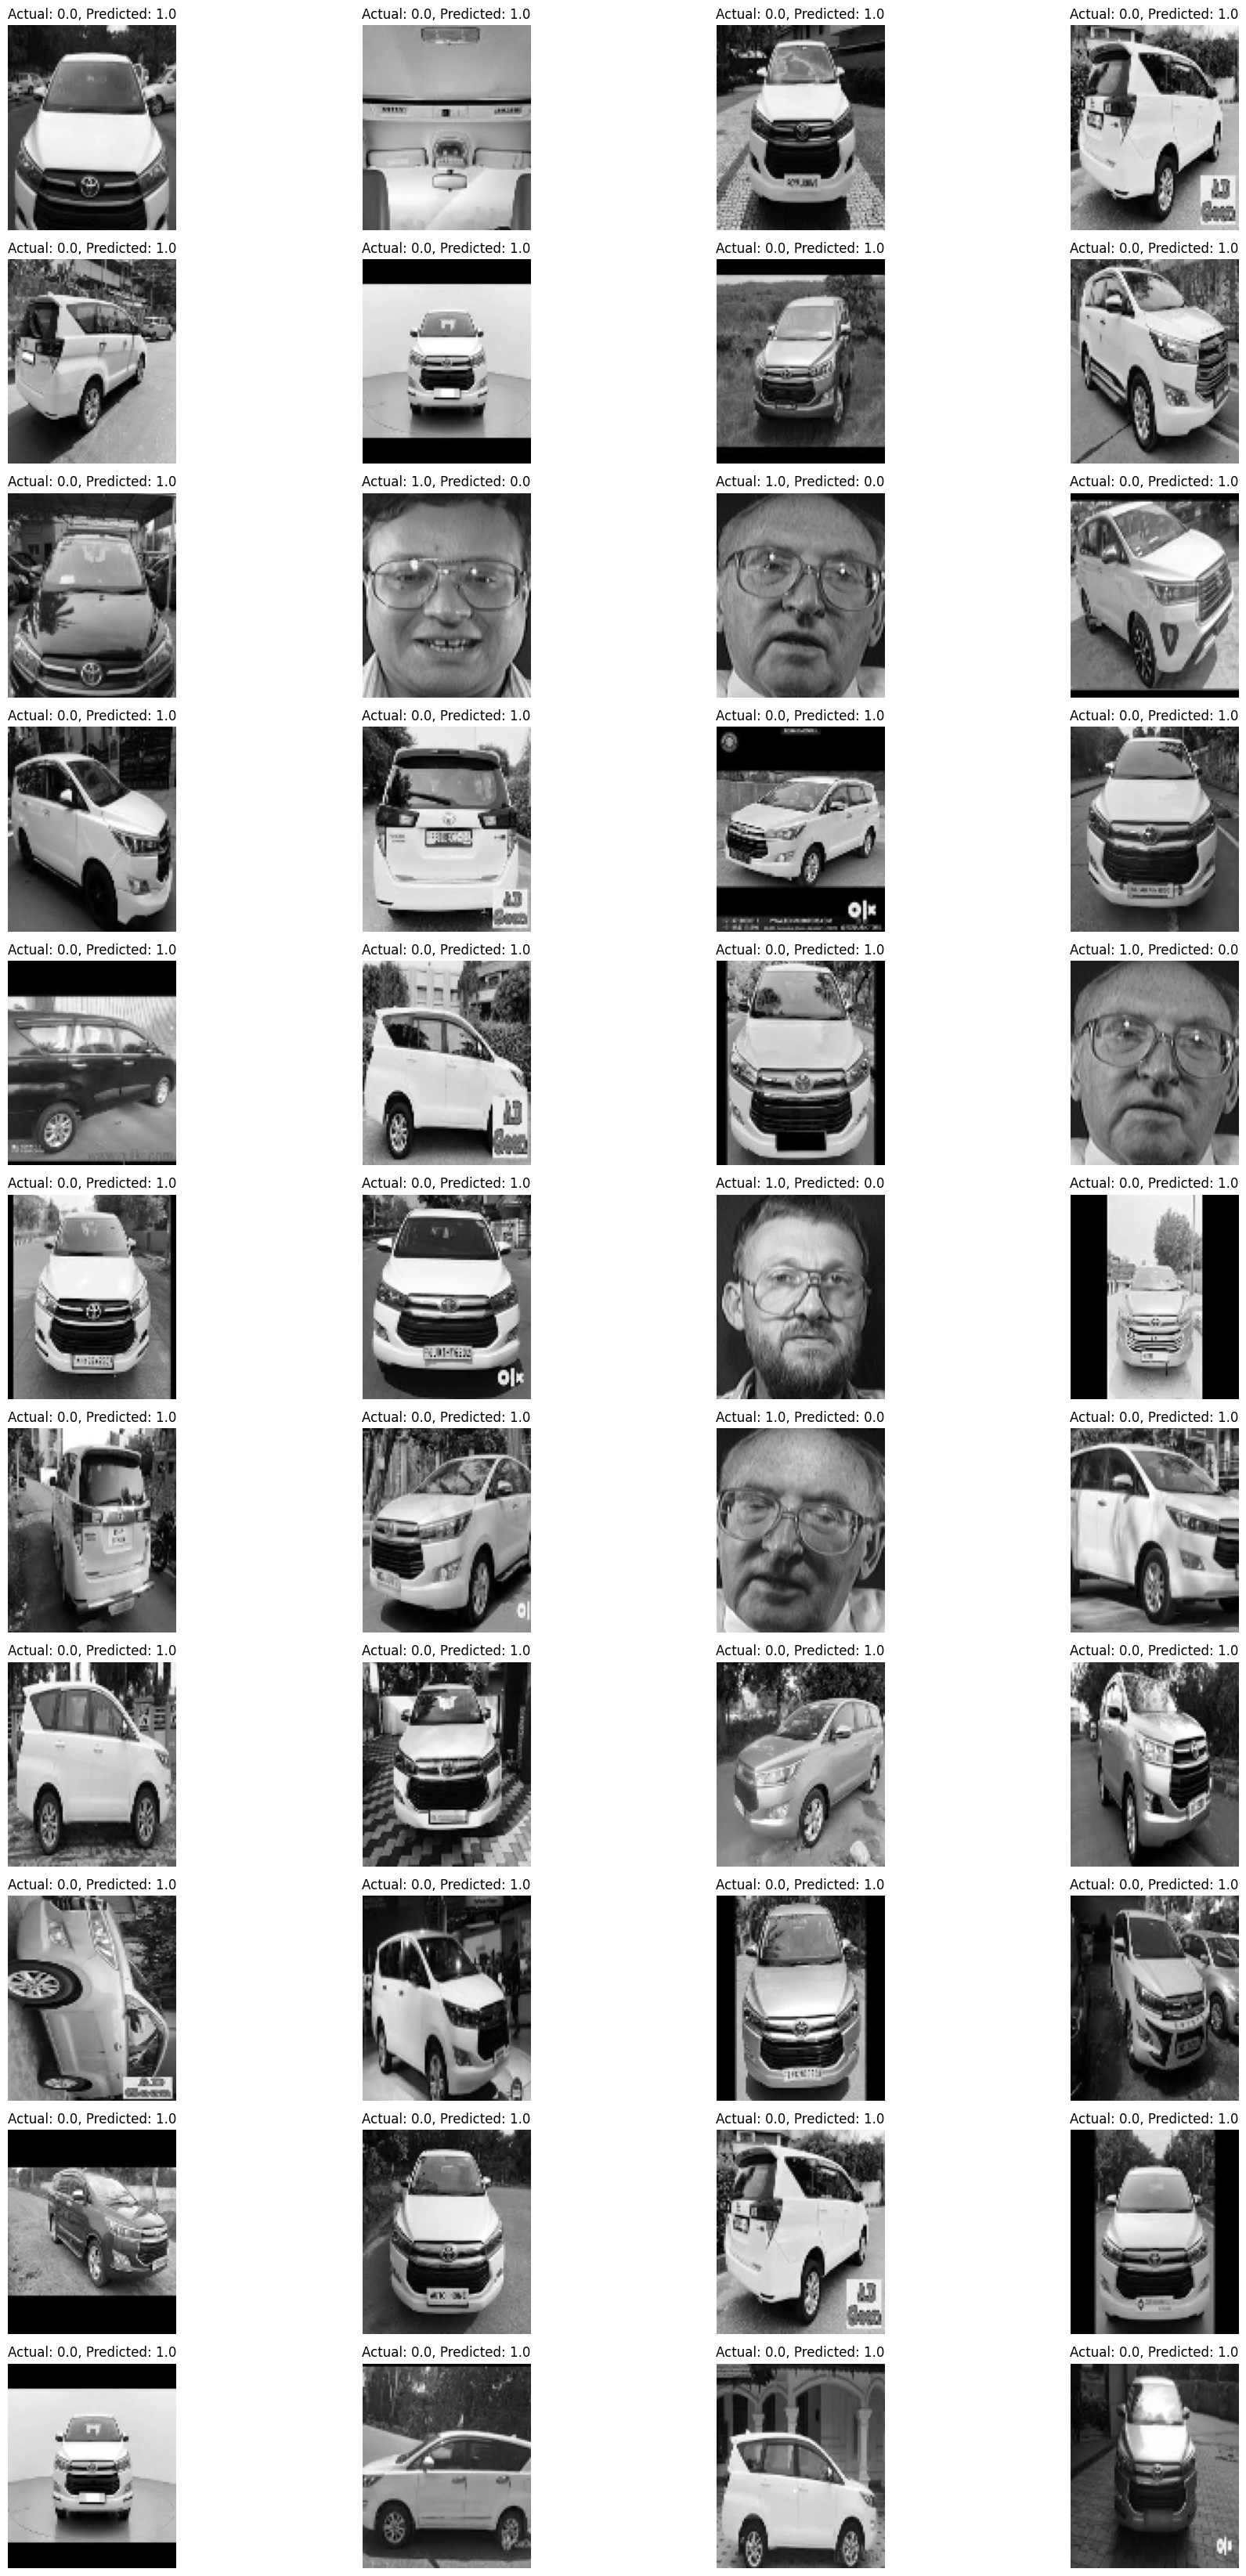

In [ ]:
print("PCA wrong prediction")
print_imgs(np.where(test_labels != prediction_pca)[0], test_labels, prediction_pca)


### PCA Correct prediction

Some PCA success cases


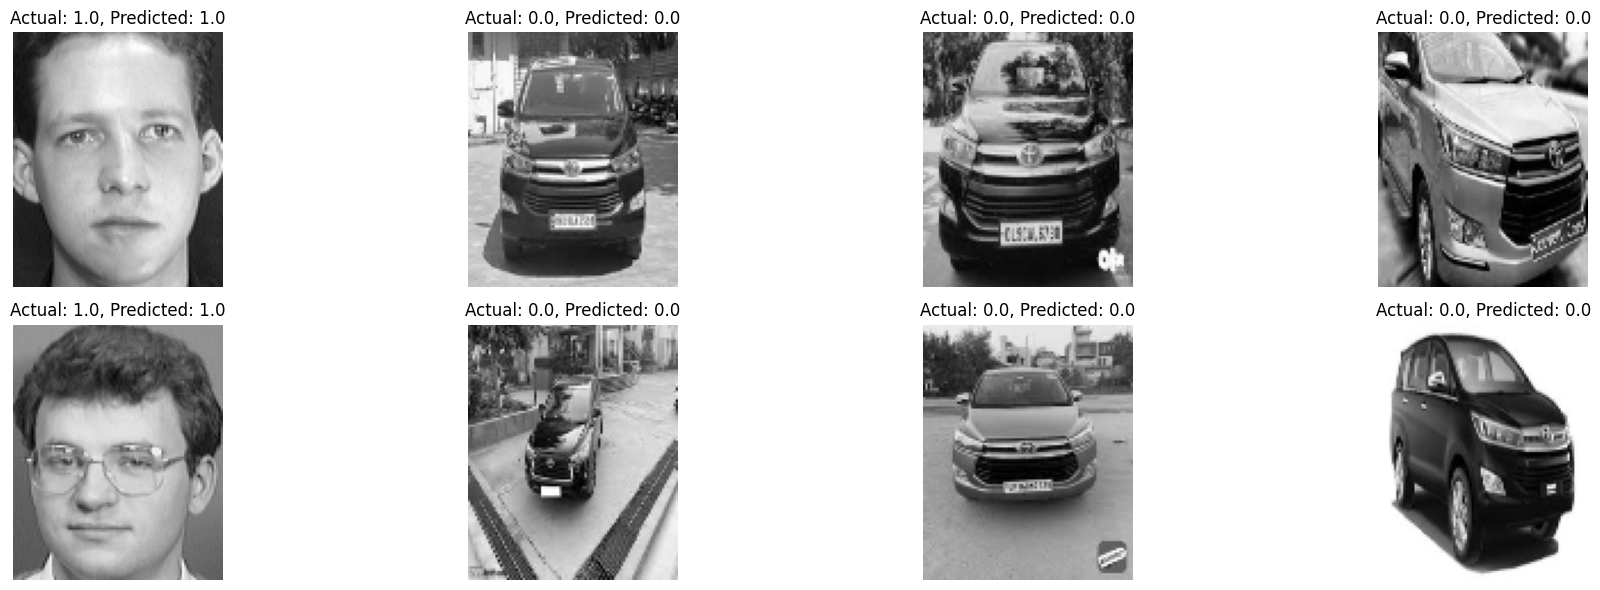

In [ ]:
print("Some PCA success cases")
print_imgs(np.where(test_labels == prediction_pca)[0][:8], test_labels, prediction_pca)

### LDA Wrong prediction

LDA wrong prediction


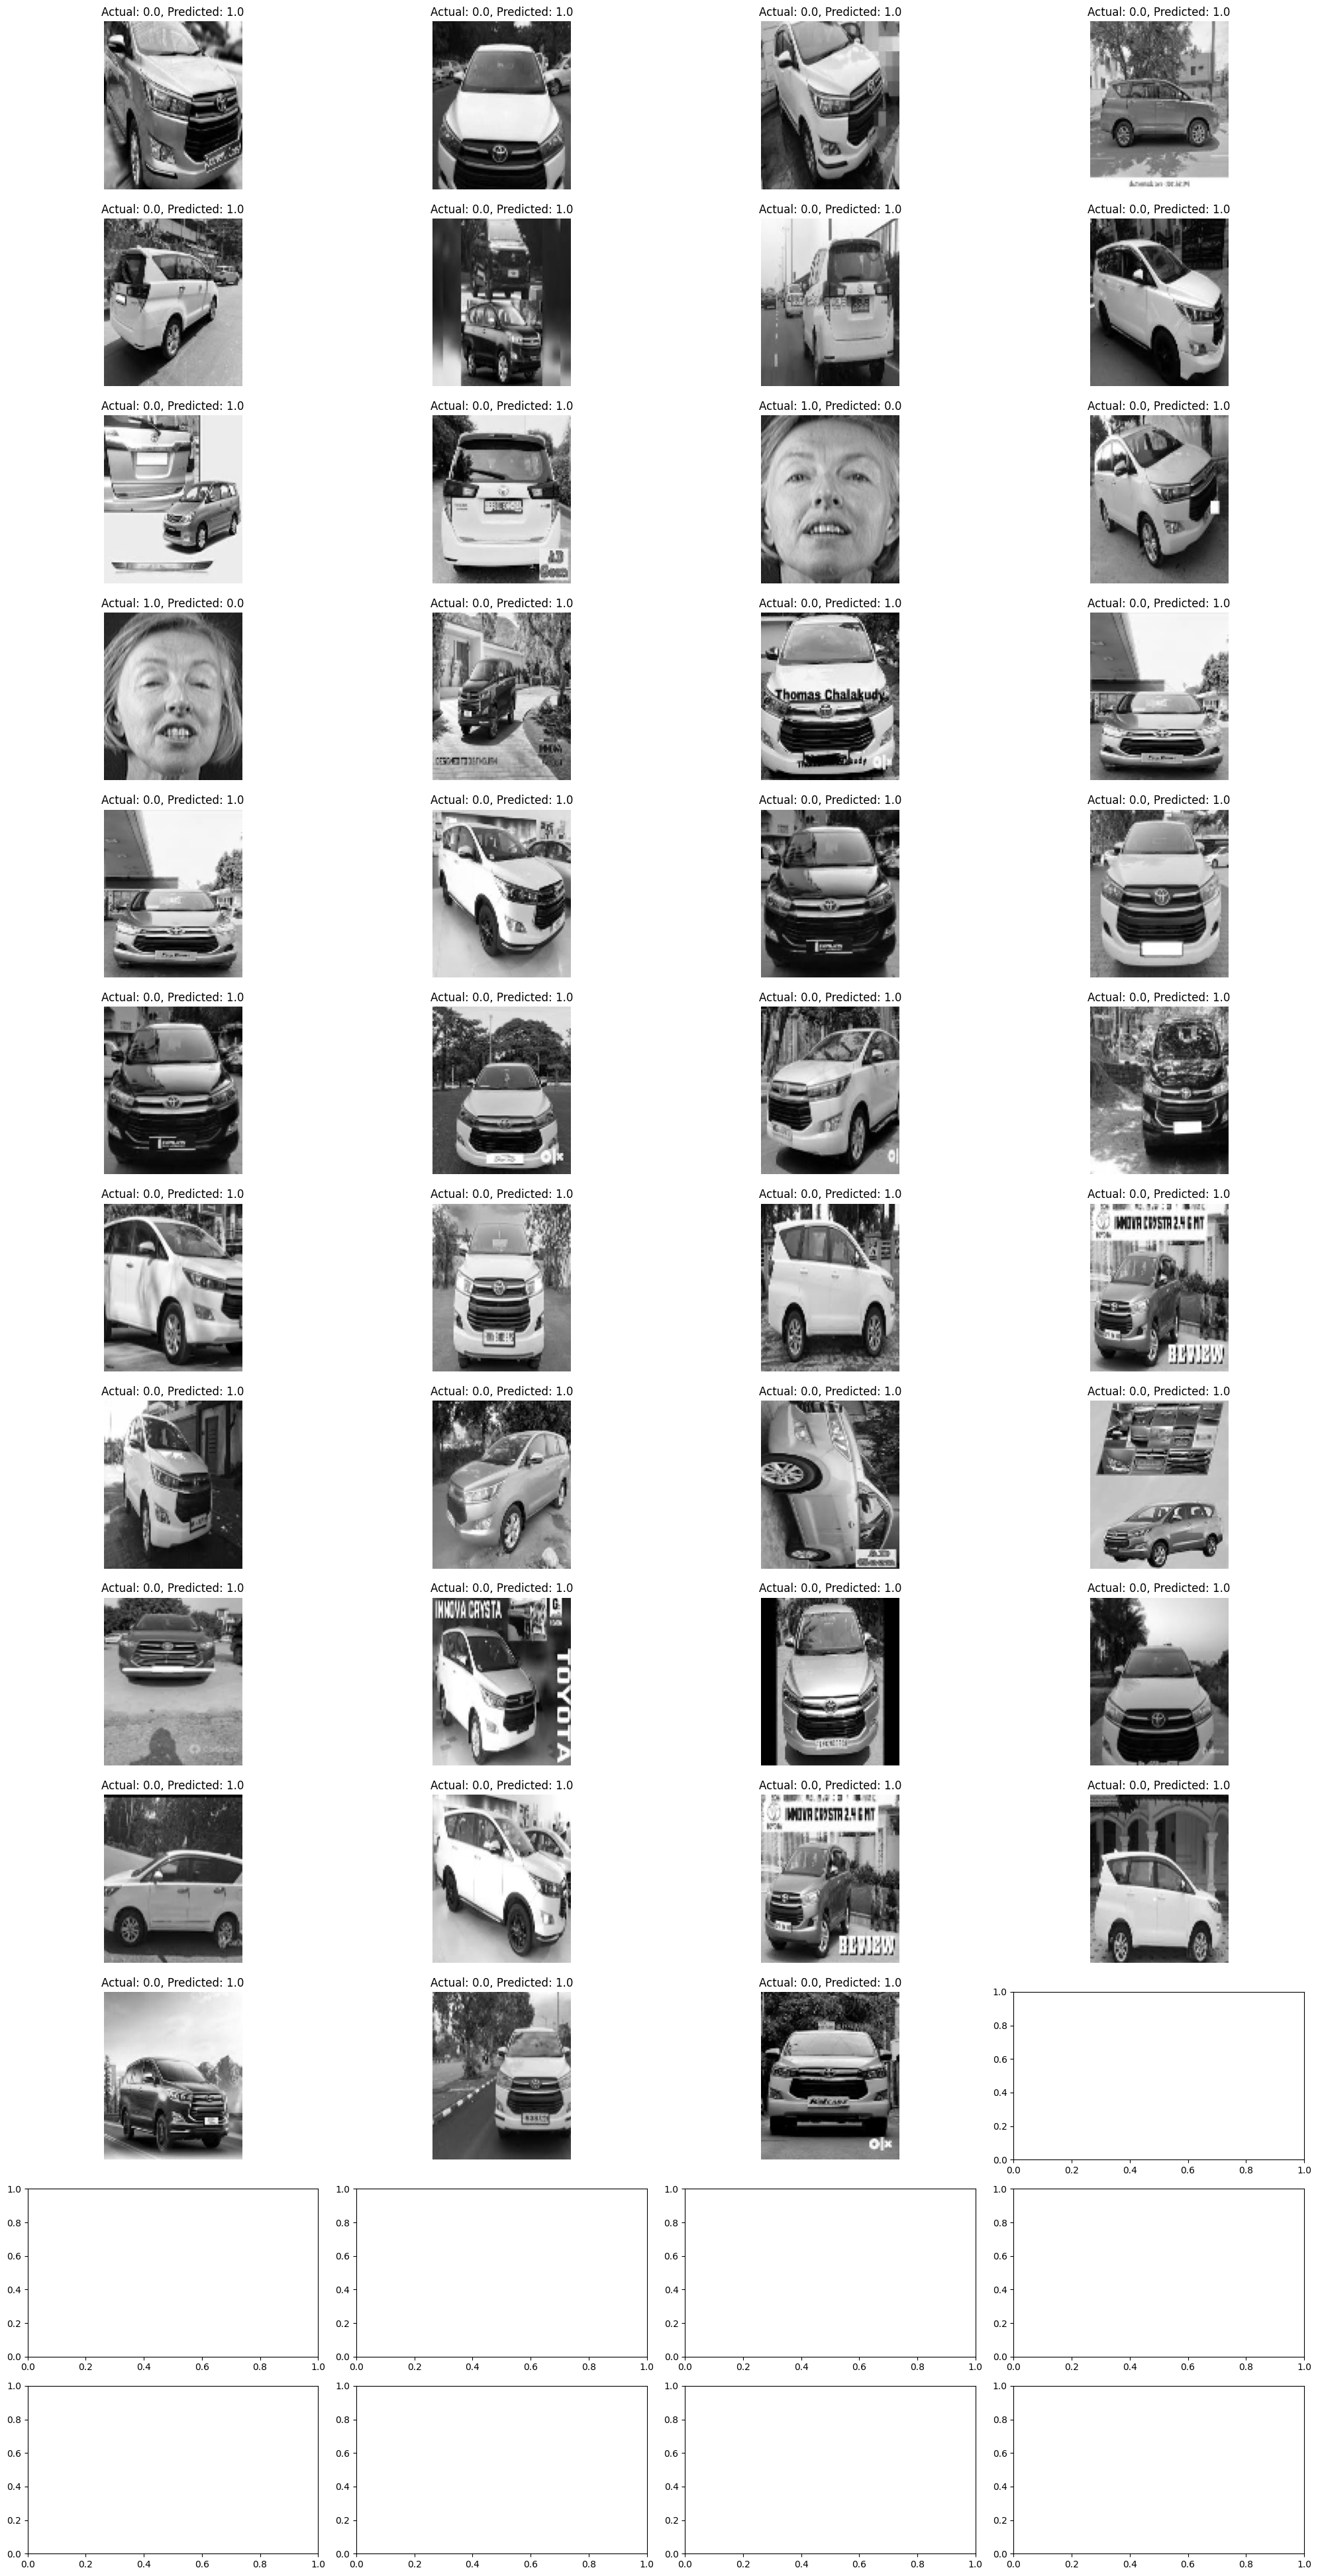

In [ ]:
print("LDA wrong prediction")
print_imgs(np.where(test_labels != prediction_lda)[0], test_labels, prediction_lda)

### LDA Correct prediction

Some LDA success cases


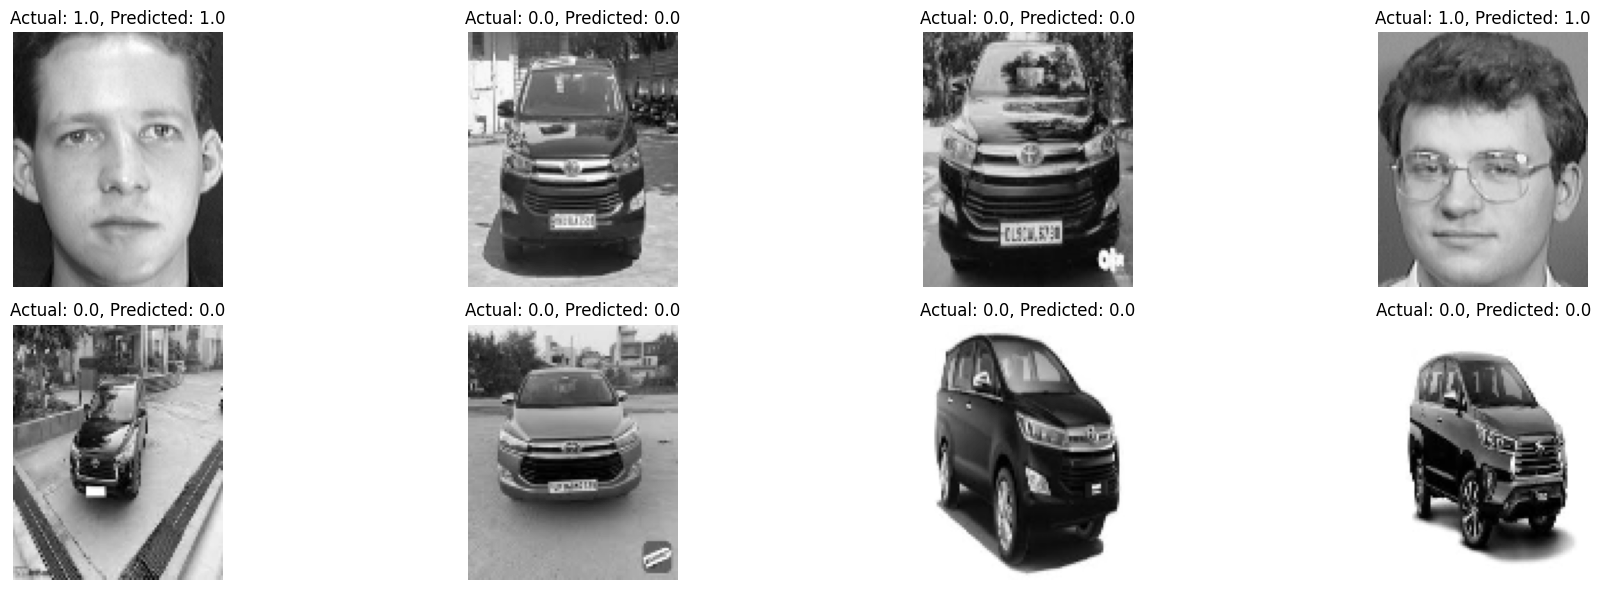

In [ ]:
print("Some LDA success cases")
print_imgs(np.where(test_labels == prediction_lda)[0][:8], test_labels, prediction_lda)

## 2. How many dominant eigenvectors will you use for the LDA solution?    
We used 1 dominant eigenvector, as we only have 2 classifications, faces vs non faces.

## Accuracy vs the number of non-face images

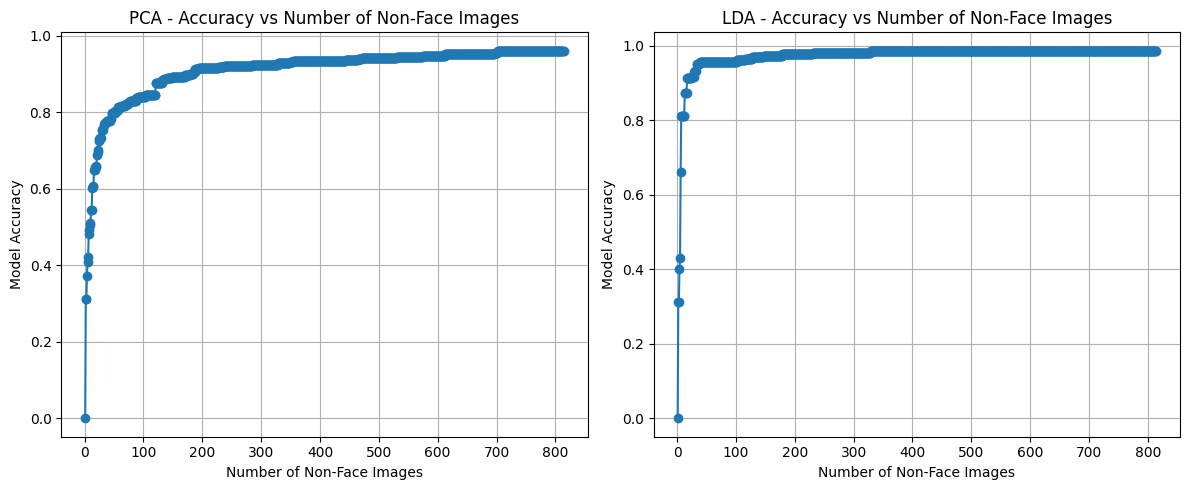

In [ ]:
train_data_acc = np.concatenate((data_matrix, nonface_images_flattened), axis=0)
train_labels_acc = np.concatenate((np.ones(data_matrix.shape[0]), np.zeros(nonface_images_flattened.shape[0])))

train_data_projected_acc_pca, test_data_projected_acc_pca, train_data_projected_acc_lda, test_data_projected_acc_lda = prepare_test_data(train_data_acc, test_data, train_labels_acc)


def get_accuracy_nonfaces(train_data, train_labels, test_data, test_labels):
  predictions = np.zeros(number_of_images)
  for i in range(1, number_of_images):
    train_acc = train_data[:data_matrix.shape[0] + i]
    train_lab = train_labels[:data_matrix.shape[0] + i]
    prediction = classify_face_noface_images(train_acc, test_data, train_lab, test_labels)
    accuracy = accuracy_score(test_labels, prediction)

    predictions[i] = accuracy
  return predictions

predictions_pca = get_accuracy_nonfaces(train_data_projected_acc_pca, train_labels_acc, test_data_projected_acc_pca, test_labels)
predictions_lda = get_accuracy_nonfaces(train_data_projected_acc_lda, train_labels_acc, test_data_projected_acc_lda, test_labels)

plt.figure(figsize=(12, 5))

# PCA Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, number_of_images + 1), predictions_pca, marker='o')
plt.xlabel('Number of Non-Face Images')
plt.ylabel('Model Accuracy')
plt.title('PCA - Accuracy vs Number of Non-Face Images')
plt.grid(True)

# LDA Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, number_of_images + 1), predictions_lda, marker='o')
plt.xlabel('Number of Non-Face Images')
plt.ylabel('Model Accuracy')
plt.title('LDA - Accuracy vs Number of Non-Face Images')
plt.grid(True)

plt.tight_layout()
plt.show()

We notice that as the number of non-face images increase, our accuracy increases. This might be a bad indicator as is explained below.



## Criticize the accuracy measure for large numbers of non-faces images in the training data.

If the number of non-face images is much greater than the number of faces, the classifier will be biased towards non-faces. So accuracy would always be high but it wouldn’t be effective for classifying faces.    

Accuracy will be misleading in this case, as it cannot identify faces very well.


# Bonus


## 1. Different Training and Test splits

Split the data matrix into training set and test set with ratio<br>
70 : 30 <br>
instead of<br>
50 : 50

In [ ]:
def split_data_7_3(data_matrix, labels):
  training_set_7_3 = []
  test_set_7_3 = []

  training_set_labels_7_3 = []
  test_set_labels_7_3 = []
  for i in range(0, len(data_matrix), 10):
    training_set_7_3.extend(data_matrix[i:i+7])
    test_set_7_3.extend(data_matrix[i+7:i+10])
    training_set_labels_7_3.extend(labels[i:i+7])
    test_set_labels_7_3.extend(labels[i+7:i+10])

  training_set_7_3 = np.array(training_set_7_3)
  test_set_7_3 = np.array(test_set_7_3)

  training_set_labels_7_3 = np.array(training_set_labels_7_3)
  test_set_labels_7_3 = np.array(test_set_labels_7_3)
  return training_set_7_3, training_set_labels_7_3, test_set_7_3, test_set_labels_7_3

In [ ]:
training_set_7_3, training_set_labels_7_3, test_set_7_3, test_set_labels_7_3 = split_data_7_3(data_matrix, labels)
print(training_set_labels_7_3)
print("")
print(test_set_labels_7_3)

[ 1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.
  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  6.
  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.
  8.  8.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 11. 11.
 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13.
 13. 14. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 16. 16. 16.
 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20. 20. 20. 21. 21. 21. 21.
 21. 21. 21. 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 23. 24.
 24. 24. 24. 24. 24. 24. 25. 25. 25. 25. 25. 25. 25. 26. 26. 26. 26. 26.
 26. 26. 27. 27. 27. 27. 27. 27. 27. 28. 28. 28. 28. 28. 28. 28. 29. 29.
 29. 29. 29. 29. 29. 30. 30. 30. 30. 30. 30. 30. 31. 31. 31. 31. 31. 31.
 31. 32. 32. 32. 32. 32. 32. 32. 33. 33. 33. 33. 33. 33. 33. 34. 34. 34.
 34. 34. 34. 34. 35. 35. 35. 35. 35. 35. 35. 36. 36

**PCA**

In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]

for i in alpha:
  projection_matrix          =     PCA(training_set_7_3, i)

  projected_train = np.dot(training_set_7_3, projection_matrix)
  projected_test = np.dot(test_set_7_3, projection_matrix)

  knn_classifier             =    KNeighborsClassifier(n_neighbors=1)
  knn_classifier.fit(projected_train, training_set_labels_7_3)
  predicted_labels           =    knn_classifier.predict(projected_test)

  accuracy                   =    accuracy_score(test_set_labels_7_3, predicted_labels)
  print("Alpha:", i, ",  Accuracy:", accuracy)

(10304, 10304)
Alpha: 0.8 ,  Accuracy: 0.9583333333333334
(10304, 10304)
Alpha: 0.85 ,  Accuracy: 0.9666666666666667
(10304, 10304)
Alpha: 0.9 ,  Accuracy: 0.9666666666666667
(10304, 10304)
Alpha: 0.95 ,  Accuracy: 0.95


**LDA**

In [ ]:
proj_matrix = LDA(training_set_7_3, training_set_labels_7_3, 39)

In [ ]:
projected_train = np.dot(training_set_7_3, proj_matrix)
projected_test = np.dot(test_set_7_3, proj_matrix)

accuracies = []
k_values = [1, 3, 5, 7]

for k in k_values:
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(projected_train, training_set_labels_7_3)
  predicted_labels = knn_classifier.predict(projected_test)
  accuracy = accuracy_score(test_set_labels_7_3, predicted_labels)
  print("Accuracy for K = " , k," = ", accuracy)
  accuracies.append(accuracy)

plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.show()


## Kernel PCA

Kernel PCA works by using a kernel function to map our data into a higher dimensional vector space. This is considered a non-linear transformation of our data. This is useful in data that is non-linear, like manifolds. This algorithm works better in case the data is evenly distributed on the manifold. It does a better job in seperating the data from each other than normal PCA, as no linear transformation can seperate non-linear data.    

Instead of using a convariance matrix, KPCA uses a pair-wise kernel function to calculate similary between points, then it projects the data into a lower dimension, through a non-linear transformation.

In [ ]:
def KPCA(train_data, train_labels, test_data, test_labels):
  kernel_pca = KernelPCA(n_components=None, kernel='linear')
  # kernel_pca = kernel_pca.fit(train_data)
  train_data_projected = kernel_pca.fit_transform(train_data)
  test_data_projected = kernel_pca.transform(test_data)

  knn_classifier = KNeighborsClassifier(n_neighbors=3)
  knn_classifier.fit(train_data_projected, train_labels)
  predicted_labels = knn_classifier.predict(test_data_projected)

  accuracy = accuracy_score(test_set_labels, predicted_labels)
  return accuracy

KPCA(training_set, training_set_labels, test_set, test_set_labels)

0.895

## 2. B. Quadratic discriminate analysis


Quadratic discrimnate analysis is smiilar to Linear, <br>
However, QDA doesn't assume same covarince matrix for all classes and calculate different covariance matrix for each class, oppsing to LDA which assumes all classes have same covariance matrix.<br>

The basic idea of QDA is, having diffrerent covariances for each class, also each class assumed to be Gaussian Model,

We want to find the boundaries that satify, that their Mahalanobis distance to each pair of the classes are same and so they can follow any distribution (not only linear as in LDA).<br>

This gives more flexibility to boundaries to follow any shape and give better classification.

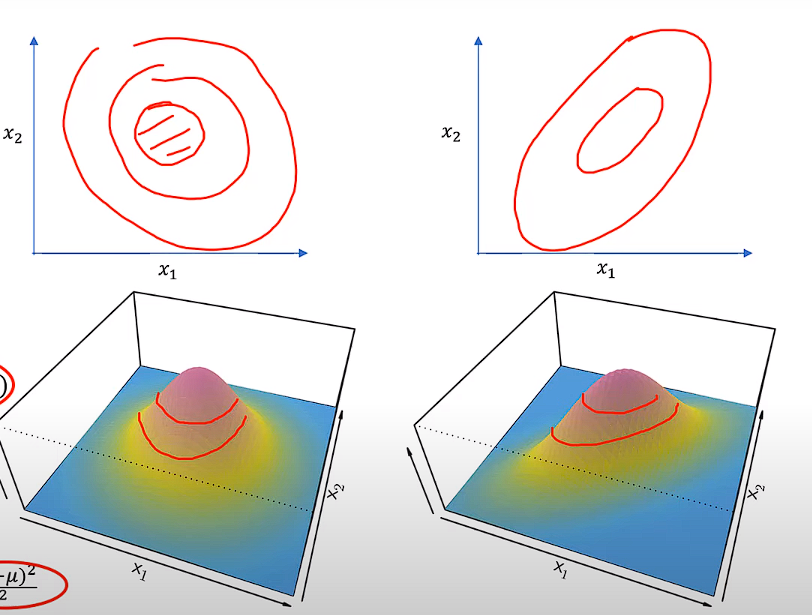

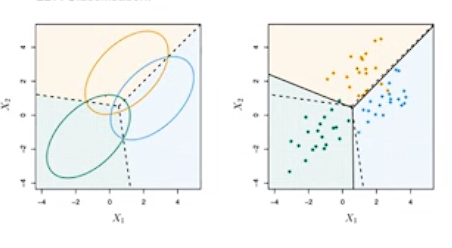

In [ ]:
def QDA(train_data, train_labels, test_data, test_labels):
  qda = QuadraticDiscriminantAnalysis()
  qda.fit(train_data, train_labels)

  pred_labels = qda.predict(test_data)
  accuracy = accuracy_score(test_labels, pred_labels)
  print(accuracy)
  return accuracy

QDA(projected_train, training_set_labels, projected_test, test_set_labels)

0.22


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.22

Accuracy for QDA is 0.22 Which is much worse than our LDA implementation, which is 0.945

Time for QDA is less than a second, while the time it takes for our implemenetation is ~30m